In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import sys
sys.path.insert(0, './libraries')
from DataGenerator import DataGenerator
import tensorflow as tf
from Speckle2Void import Speckle2V

from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

%reload_ext autoreload
%autoreload 2


2023-11-19 17:32:15.468282: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 17:32:15.961257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 17:32:15.963939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 17:32:16.937025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Instantiate the model

In [3]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
batch_size=16

dir_train = "../DataSet_SAR/TerraSAR_X/HDF5_SLC_DECORRELATED_2/"
dir_test = "../DataSet_SAR/TerraSAR_X/HDF5_SLC_TEST_DECORRELATED_2/"

file_checkpoint = 's2v_checkpoint/model.ckpt-299999'#None for the latest checkpoint

model = Speckle2V(dir_train,
                  dir_test,
                  file_checkpoint,
                  batch_size=batch_size,
                  patch_size=64,
                  model_name='speckle2void',
                  lr=1e-04, 
                  steps_per_epoch=2000,
                  k_penalty_tv=5e-05,
                  shift_list=[3,1],
                  prob = [0.9,0.1],
                  clip=500000,
                  norm=100000,
                  L_noise=1)    

2023-11-19 17:32:22.844745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-19 17:32:22.844774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: araticum
2023-11-19 17:32:22.844780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: araticum
2023-11-19 17:32:22.844849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-11-19 17:32:22.844868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.129.3
2023-11-19 17:32:22.844872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.129.3


## Build the inference computational graph and load the network

In [4]:
model.build_inference()
model.load_weights()

Instructions for updating:
Colocations handled automatically by placer.


/home/jp/Documents/IME/TCC/CODE/my_project_v2/Speckle2Void.py:231: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x1 = tf.compat.v1.layers.batch_normalization(x1, axis=-1,training=self.is_train,name='bn_{0}'.format(i+1))
/home/jp/Documents/IME/TCC/CODE/my_project_v2/Speckle2Void.py:263: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x1 = tf.compat.v1.layers.batch_normalization(x1, axis=-1,training=self.is_train,name='bn_{0}'.format(i+1))
2023-11-19 17:32:29.955245: I te

Taking the specified checkpoint...
INFO:tensorflow:Restoring parameters from s2v_checkpoint/model.ckpt-299999


## Speckle2Void Prediction

In [51]:
dir_test = "/home/jp/Documents/IME/TCC/CODE/my_project_v2/test_examples"
datagen = DataGenerator()
imgs = datagen.load_imgs_from_directory(directory = dir_test,filter='*.mat',max_files=None)

Reading /home/jp/Documents/IME/TCC/CODE/my_project_v2/test_examples/area3_RGB.mat...


In [6]:
imgs = [img[:,0:1000,0:1000,:] for img in imgs]

In [53]:
import rasterio
image_for_decorrelation = '/home/jp/Documents/IME/TCC/CODE/my_project_v2/test_examples/RGB_AREA_X03_S1.tif'
c = rasterio.open(image_for_decorrelation)
d = c.read()

In [55]:
imgs[0].shape

(1, 2026, 1984, 1)

In [60]:
e.shape

(2026, 1984, 1)

In [61]:
new_array = np.expand_dims(e, axis=0)
new_array.shape

(1, 2026, 1984, 1)

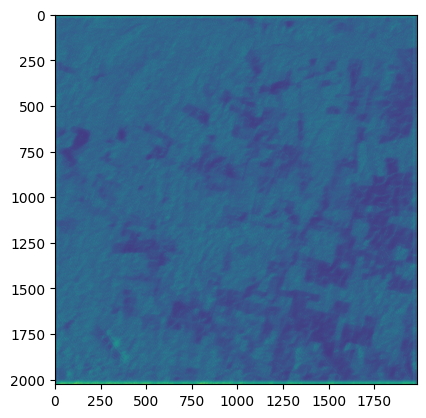

In [68]:
plt.imshow(cleaned_img[0])

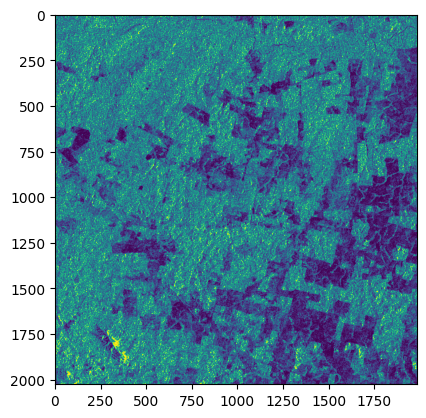

In [59]:
e = d[:, :, 0:1]
e.shape
plt.imshow(e)

In [62]:
cleaned_img= model.predict(new_array)

2023-11-19 20:35:52.831837: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4116054016 exceeds 10% of free system memory.


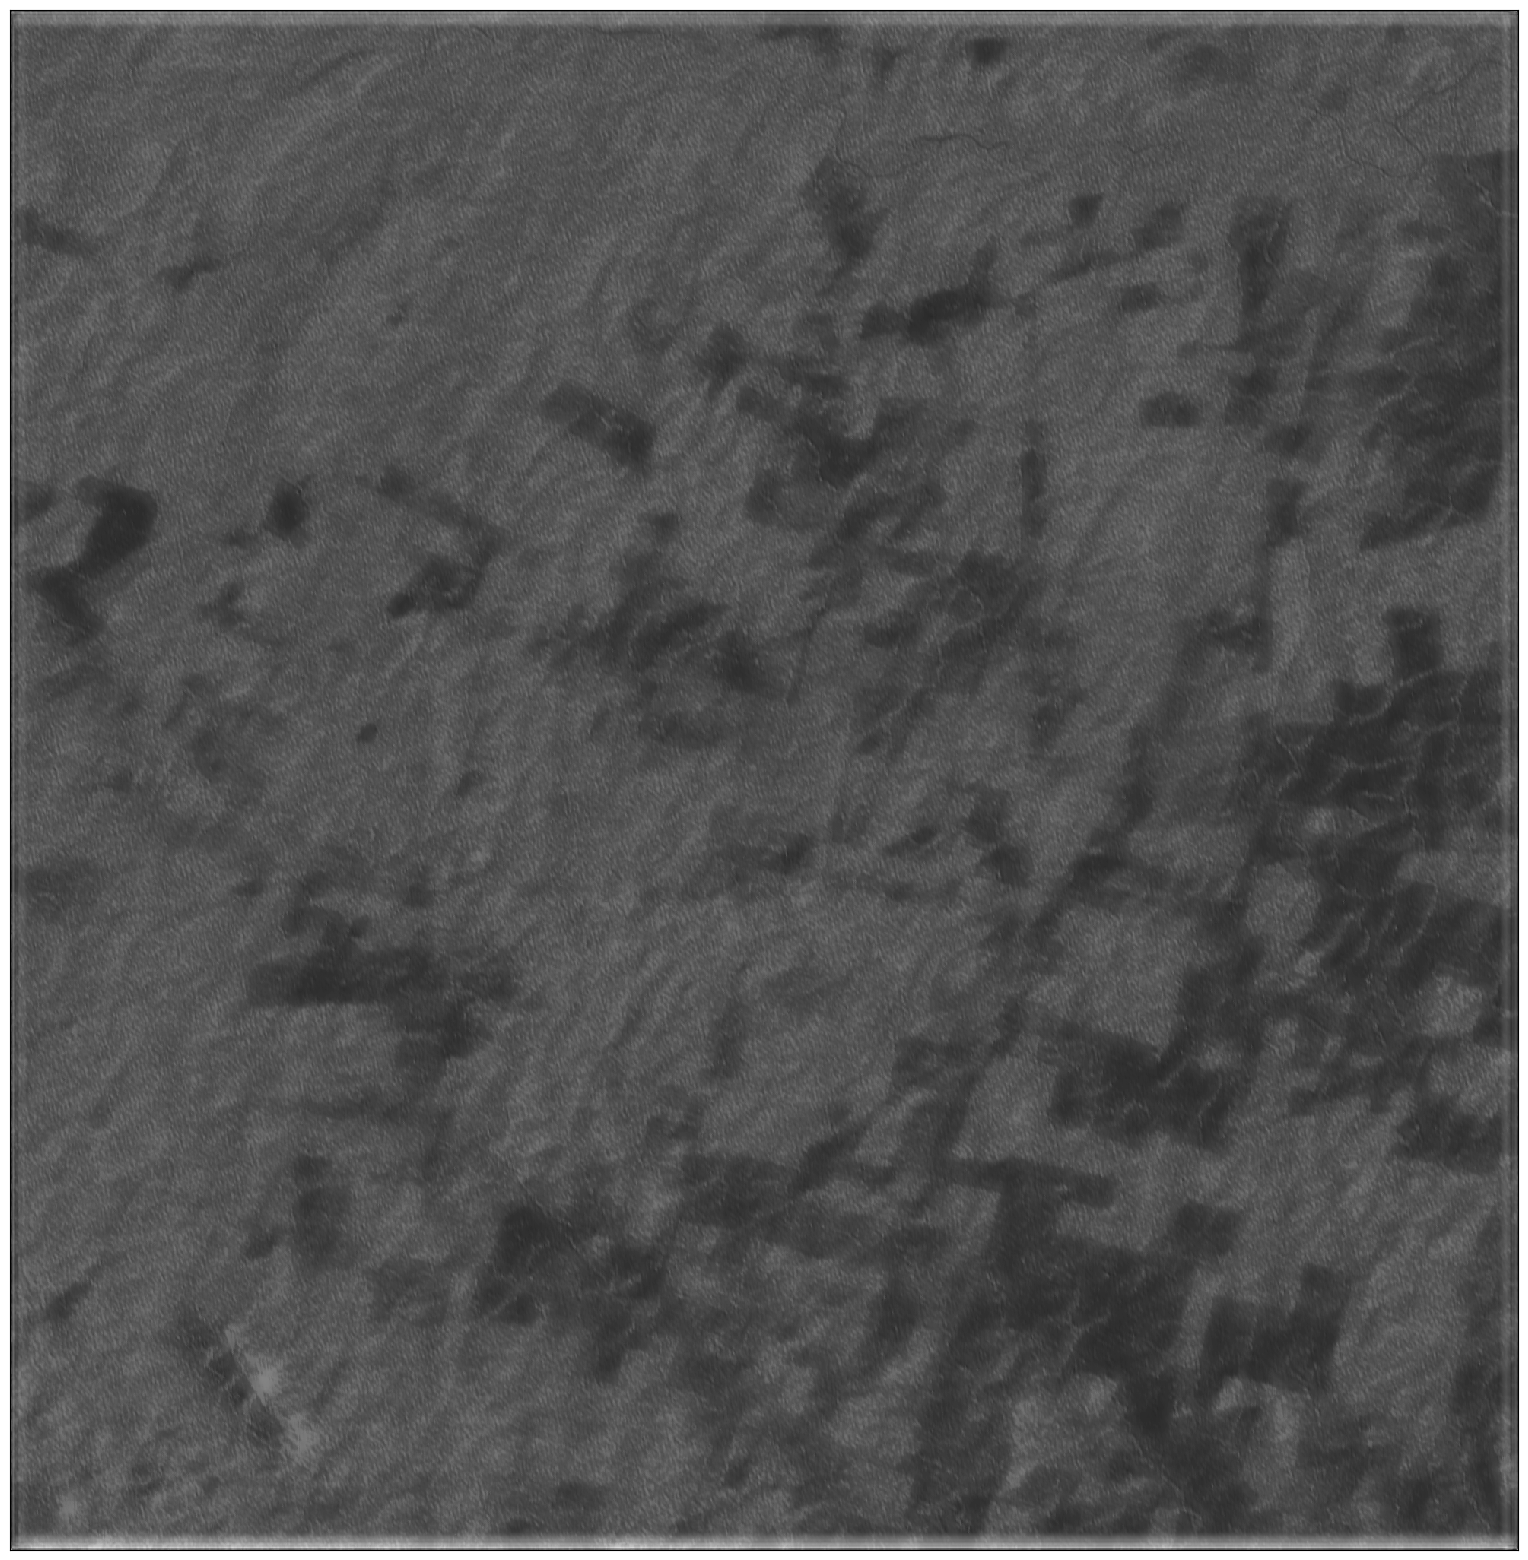

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,20])
plt.imshow(cleaned_img[0,:,:,0] ,cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

## Save image to png

In [71]:
plt.imsave('area3_RGB_despeckle.png',cleaned_img[0,:,:,0] , cmap='gray')

In [13]:
type(cleaned_img)

numpy.ndarray

/home/jp/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


grayscale shape: (843, 1230, 3)


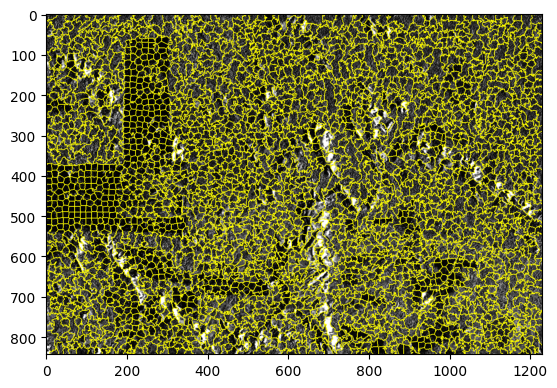

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area1_despeckle.png')
grayscale = rescale_img(grayscale_src, 843, 1230)
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
# plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_rescale.npy', grayscale_slic)

In [10]:
def rescale_img(src, w, h):
    data = src.read(
        out_shape=(
            src.count,
            w,
            h
        ),
        )

# scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )

    return data

/home/jp/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


grayscale shape: (998, 977, 3)


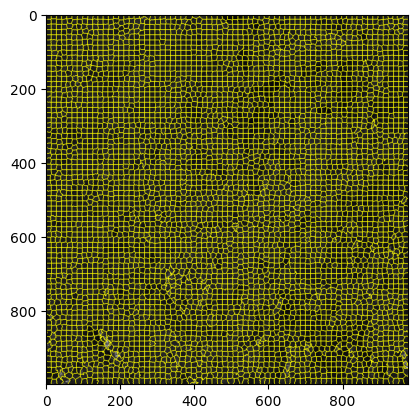

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/area3_despeckle.png')
grayscale = rescale_img(grayscale_src, 998, 977)
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
# plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/despeckle_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_despeckle_rescale.npy', grayscale_slic)

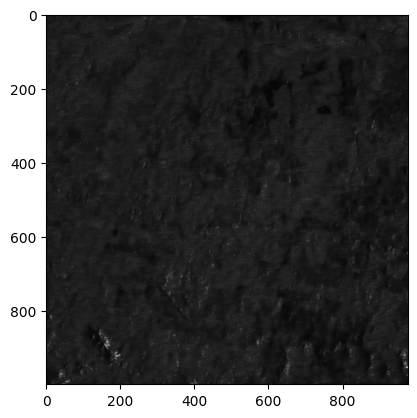

In [12]:
plt.imshow(grayscale)

grayscale shape: (998, 977, 3)


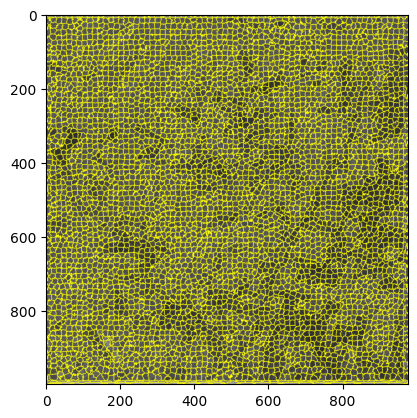

In [78]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/area3_RGB_despeckle.png')
grayscale = rescale_img(grayscale_src, 998, 977)
# grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_despeckle_slic_resize.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_despeckle_resize.npy', grayscale_slic)

grayscale shape: (2026, 1984, 3)


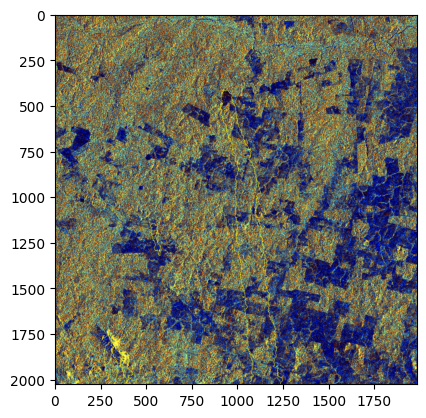

In [79]:
grayscale_src = rasterio.open('/home/jp/Documents/IME/TCC/CODE/my_project_v2/test_examples/RGB_AREA_X03_S1.tif')
# grayscale = rescale_img(grayscale_src, 998, 977)
grayscale = grayscale_src.read()
grayscale = grayscale[:3, :, :]
grayscale = grayscale.transpose(1, 2, 0)
plt.imshow(grayscale)
print(f'grayscale shape: {grayscale.shape}')
grayscale_slic = seg.slic(grayscale, n_segments=5000)
grayscale_with_bounds = seg.mark_boundaries(image=grayscale, label_img=grayscale_slic)
plt.imshow(grayscale_with_bounds)
plt.imsave('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_RAW_slic.png', grayscale_with_bounds)
np.save('/home/jp/Documents/IME/TCC/NEW/saved_segmentations/area3_RGB_RAW.npy', grayscale_slic)